# Investigating DISC1

In [12]:
import functools
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

from plotnine import *
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [13]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [14]:
feature = 'genes'
config = {
    'deg_file': '../../_m/%s/diffExpr_maleVfemale_full.txt' % feature,
    'res_file': '../../_m/%s/residualized_expression.tsv' % feature,
    'pheno_file': '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv',
}

In [15]:
@functools.lru_cache()
def get_de():
    ''' Take DE genes obtained from limma-voom pipeline.
    '''
    return pd.read_csv(config['deg_file'], sep='\t').sort_values('adj.P.Val')


@functools.lru_cache()
def get_residualized():
    '''Load residualization file.
    '''
    return pd.read_csv(config['res_file'], sep='\t', index_col=0).transpose()


@functools.lru_cache()
def get_pheno_data():
    return pd.read_csv(config['pheno_file'], index_col=0)

In [4]:
def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)

In [5]:
de_df = get_de()
de_df[(de_df.Symbol == 'DISC1')]

,Length,gencodeID,ensemblID,gene_type,Symbol,EntrezID,Class,meanExprs,NumTx,logFC,AveExpr,t,P.Value,adj.P.Val,B,CtrlvsSZ,MvsF,Interaction
ENSG00000162946.20,12906,ENSG00000162946.20,ENSG00000162946,protein_coding,DISC1,27185.0,InGen,0.467991,23,0.0757,3.551401,2.234168,0.026072,0.580967,-6.180898,0,0,0


In [6]:
res_df = get_residualized()
disc1 = pd.DataFrame({'DISC1': res_df[de_df[(de_df.Symbol == 'DISC1')].index.values[0]]})
pheno_df = get_pheno_data()
df = pheno_df.merge(disc1, right_index=True, left_index=True)
df.Sex = df.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})
df.Dx = df.Dx.astype('category').cat.rename_categories({'Schizo': 'SZ', 'Control': 'CTL'})
df.head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,DISC1
R12864,Br1303,R12864,Caudate,9.6,42.98,Female,AA,SZ,-1.701212
R12865,Br1320,R12865,Caudate,9.5,53.12,Male,AA,SZ,1.449046


In [7]:
f, p = mannwhitneyu(df[(df['Sex'] == 'Female')].DISC1, df[(df['Sex'] == 'Male')].DISC1)
print("DISC1 expression between genders:\nP-value:%.2e" % p)

female = df[(df['Sex'] == 'Female')].copy()
male = df[(df['Sex'] == 'Male')].copy()

f, p = mannwhitneyu(female[(female['Dx'] == 'CTL')].DISC1, female[(female['Dx'] == 'SZ')].DISC1)
print("Female DISC1 expression:\nP-value:%.2e" % p)

f, p = mannwhitneyu(male[(male['Dx'] == 'CTL')].DISC1, male[(male['Dx'] == 'SZ')].DISC1)
print("Male DISC1 expression:\nP-value:%.2e" % p)

DISC1 expression between genders:
P-value:1.37e-04
Female DISC1 expression:
P-value:3.78e-03
Male DISC1 expression:
P-value:1.73e-01


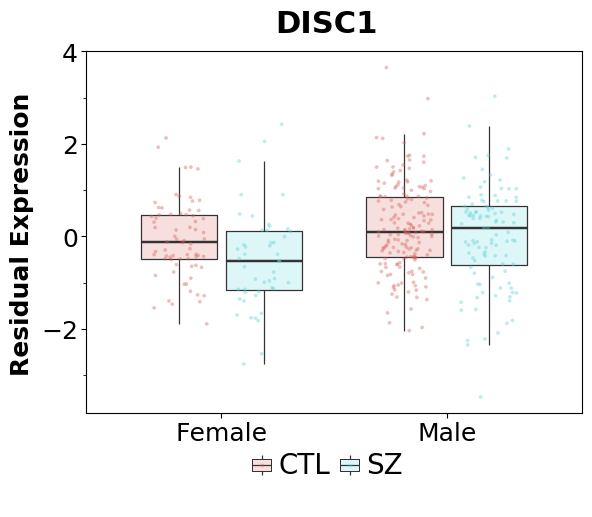

<ggplot: (8775596142102)>

In [9]:
pjd = position_jitterdodge(jitter_width=0.5)
pp = (ggplot(df, aes(x='Sex', y='DISC1', fill='Dx')) + 
      geom_boxplot(alpha=0.2, outlier_alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4) + 
      labs(x='', y='Residual Expression', title='DISC1') + 
      theme_matplotlib() + 
      theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=18, face='bold'),
            plot_title=element_text(size=22, face='bold'),
            legend_text=element_text(size=20), 
            legend_title=element_blank(), 
            legend_position="bottom"))
pp

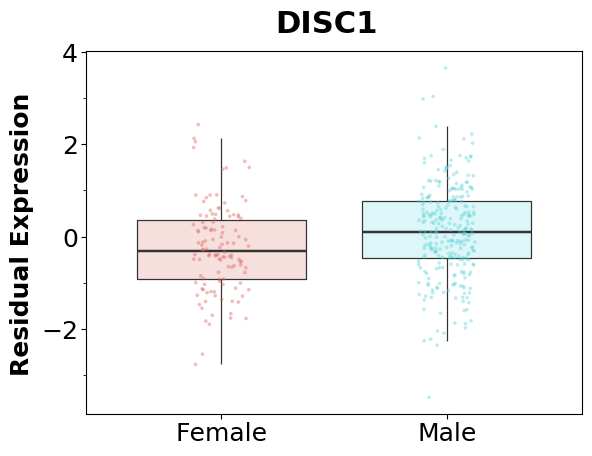

<ggplot: (8775596173050)>

In [10]:
pjd = position_jitterdodge(jitter_width=0.5)
qq = (ggplot(df, aes(x='Sex', y='DISC1', fill='Sex')) + 
      geom_boxplot(alpha=0.2, outlier_alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4) + 
      labs(x='', y='Residual Expression', title='DISC1') + 
      theme_matplotlib() + 
      theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=18, face='bold'),
            plot_title=element_text(size=22, face='bold'),
            legend_text=element_text(size=20), 
            legend_title=element_blank(), 
            legend_position="none"))
qq

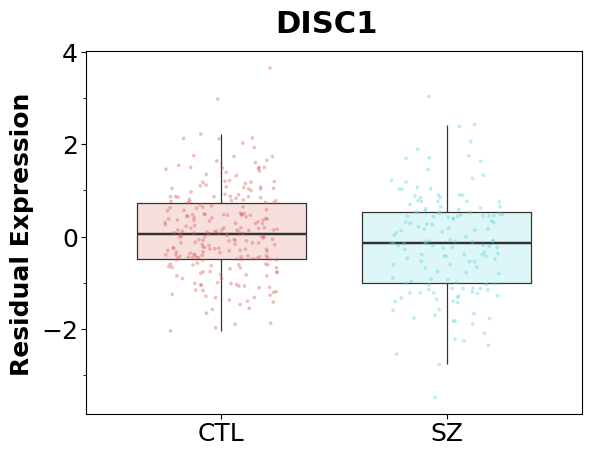

<ggplot: (8775596246806)>

In [11]:
pjd = position_jitterdodge(jitter_width=1.0)
ww = (ggplot(df, aes(x='Dx', y='DISC1', fill='Dx')) + 
      geom_boxplot(alpha=0.2, outlier_alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4) + 
      labs(x='', y='Residual Expression', title='DISC1') + 
      theme_matplotlib() + 
      theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=18, face='bold'),
            plot_title=element_text(size=22, face='bold'),
            legend_text=element_text(size=20), 
            legend_title=element_blank(), 
            legend_position="none"))
ww

In [12]:
save_plot(pp, 'disc1_interaction', width=7, height=7)
save_plot(qq, 'disc1_maleVfemale', width=7, height=7)
save_plot(ww, 'disc1_szVctl', width=7, height=7)

/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 7 x 7 in image.
  warn("Saving {0} x {1} {2} image.".format(
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: disc1_interaction.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  rcParams[key] = val
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  rcParams[key] = val
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The text.latex.unicode rcpa